## Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sources_path = './../sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
import utils
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
data_dir = './../data'
progbar = utils.ProgressBar(elapsed_time=True)
progbar.update_progress(0)

[0:00:00][----------] 0.00% 

In [175]:
# profile = pd.read_csv(os.path.join(data_dir, 'profile.csv'), sep=';', parse_dates=["became_member_on"])
df_offers = pd.read_csv(os.path.join(data_dir, 'df_offers.csv'), sep=';', parse_dates=["became_member_on"])
# transcript = pd.read_json(os.path.join(data_dir, 'transcript.json'), lines=True)
df_offers.head()

,person,time,offer_id,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,...,social,web,bogo,informational,discount,offered_reward,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,1,24,0,NaN,0.00,1,0,...,1,0,0,1,0,0,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,1,36,0,NaN,0.00,1,0,...,0,1,0,1,0,0,33.0,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1,48,1,6.0,8.57,0,1,...,1,1,1,0,0,5,33.0,2017-04-21,M,72000.0
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1,36,1,24.0,14.11,0,1,...,1,1,0,0,1,2,33.0,2017-04-21,M,72000.0
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1,36,1,0.0,10.27,0,1,...,0,1,0,0,1,2,33.0,2017-04-21,M,72000.0


## Preprocessing

Creating proper columns for the clustering algorithm

In [182]:
profile.head()

,age,became_member_on,gender,person,income,days_since_subscription,gender_clean,cluster_3,cluster_6,cluster_2
0,54.393524,2017-02-12,O,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1150,0,2,0,1
1,55.000000,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,997,-1,0,4,0
2,54.393524,2018-07-12,O,38fe809add3b4fcf9315a9694bb96ff5,64000.0,635,0,2,0,1
3,75.000000,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1064,-1,0,1,0
4,54.393524,2017-08-04,O,a03223e636434f42ac4c3df47e8bac43,64000.0,977,0,2,0,1


In [28]:
profile["days_since_subscription"] = (pd.Timestamp.today()-profile.became_member_on).dt.days

In [30]:
profile.head()

,age,became_member_on,gender,person,income,days_since_subscription
0,54.393524,2017-02-12,O,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1150
1,55.000000,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,997
2,54.393524,2018-07-12,O,38fe809add3b4fcf9315a9694bb96ff5,64000.0,635
3,75.000000,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1064
4,54.393524,2017-08-04,O,a03223e636434f42ac4c3df47e8bac43,64000.0,977


In [33]:
profile["gender_clean"] = profile.gender.map({"O": 0, "M": 1, "F": -1})

In [190]:
df_offers.head().columns

Index(['person', 'time', 'offer_id', 'offer_viewed', 'time_to_viewed',
       'offer_completed', 'time_to_completed', 'amount',
       'transaction_without_completion', 'future_purchase', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'informational',
       'discount', 'offered_reward', 'age', 'became_member_on', 'gender',
       'income', 'days_since_subscription', 'cluster_2'],
      dtype='object')

In [200]:
df_temp_1 = df_offers.groupby("person")["time", "time_to_viewed", "time_to_completed", "amount", "difficulty", "duration"].mean().reset_index(drop=False)
df_temp_2 = df_offers.groupby("person")["offer_viewed", "offer_completed", "transaction_without_completion", "future_purchase", "email", "mobile", "social", "web", "bogo", "informational"].sum().reset_index(drop=False)
df_temp = pd.merge(df_temp_1, df_temp_2, how="inner", on="person")
profile = pd.merge(profile, df_temp, how="inner", on="person")

## Cross Validation Analysis

Based on the average silhoutte score from the clustering algorithm, we want to find out what are the candidate number of clusters for a post-training analysis. 

In [183]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

In [201]:
profile.columns

Index(['age', 'became_member_on', 'gender', 'person', 'income',
       'days_since_subscription', 'gender_clean', 'cluster_3', 'cluster_6',
       'cluster_2', 'time', 'time_to_viewed', 'time_to_completed', 'amount',
       'difficulty', 'duration', 'offer_viewed', 'offer_completed',
       'transaction_without_completion', 'future_purchase', 'email', 'mobile',
       'social', 'web', 'bogo', 'informational'],
      dtype='object')

In [205]:
profile.drop(non_fit_columns, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16994 entries, 0 to 16993
Data columns (total 20 columns):
age                               16994 non-null float64
income                            16994 non-null float64
days_since_subscription           16994 non-null int64
gender_clean                      16994 non-null int64
time                              16994 non-null float64
time_to_viewed                    16994 non-null float64
time_to_completed                 12774 non-null float64
amount                            16994 non-null float64
difficulty                        16994 non-null float64
duration                          16994 non-null float64
offer_viewed                      16994 non-null int64
offer_completed                   16994 non-null int64
transaction_without_completion    16994 non-null int64
future_purchase                   16994 non-null int64
email                             16994 non-null int64
mobile                            16994 non-null i

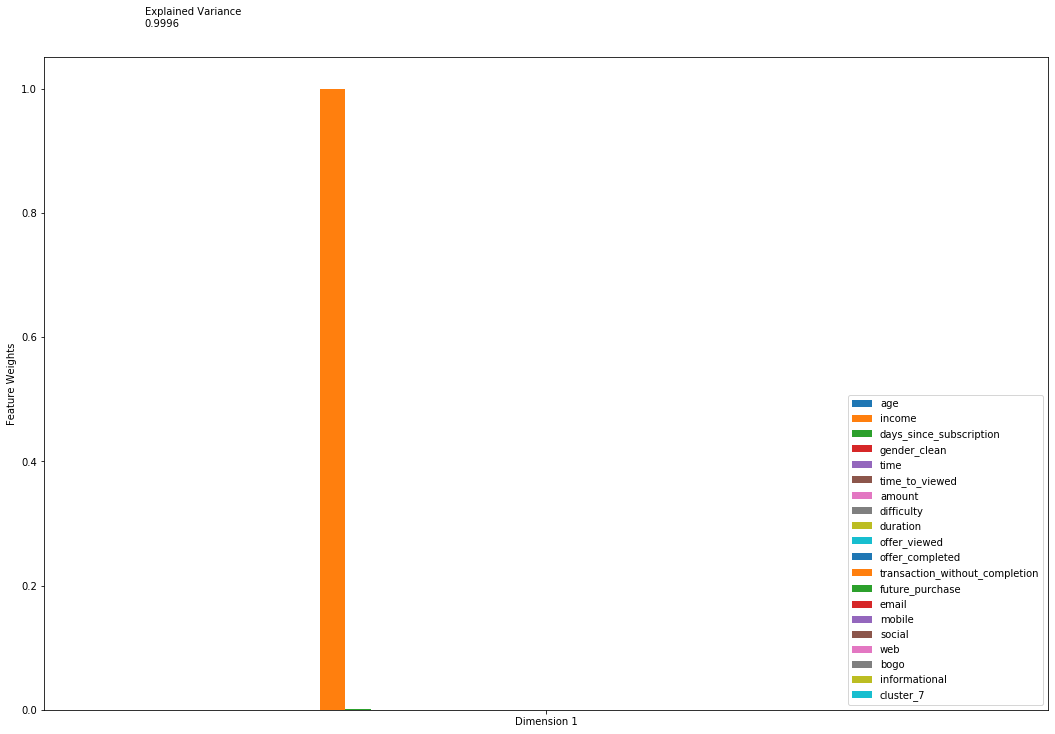

In [221]:
from sklearn.decomposition import PCA
# initialize pca class object
pca = PCA(n_components=0.95) # PCA(n_components=bc_profile.shape[1])

# define function to apply pca and visualize the results
def pca_results(df, pca):
    ''' Create a DataFrame of the PCA results that includes dimension feature 
    weights and explained variance and visusalize the results with a bar chart.

    ARGUMENTS:
        - df: dataframe
        - pca: fitted sklearn PCA class object
        
    RETURNS:
        - pca_results: dataframe with pca results
        - Plot of PCA results (bar chart)
    '''
    
    pca.fit(df)

    # index dimensions, pca components, explained variance
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(df.keys()))
    components.index = dimensions
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # create a bar plot visualization: plot feature weights as function of components
    fig, ax = plt.subplots(figsize = (18,12))

    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    plt.legend(loc='lower right')

    # display explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n%.4f"%(ev))

    # return concatenated DataFrame
    pca_results = pd.concat([variance_ratios, components], axis = 1)
    pca_results
    
pca_results(profile.drop(non_fit_columns, axis=1), pca)

In [208]:
non_fit_columns = ["became_member_on", "gender", "person", "cluster_3", "cluster_6", 
                  "cluster_2", "time_to_completed"]
silhouette_avg = list()
n_clusters = np.arange(2, 11, 1)
X = profile.drop(non_fit_columns, axis=1).values
df_silhouette_avg = pd.DataFrame(columns = ["fold", "n_cluster", "train_silhouette", "test_silhouette"])
trained_models = list()
fold = -1

sss = StratifiedShuffleSplit(n_splits=5)

for train_index, test_index in sss.split(X, np.zeros(len(X))):        
    fold += 1
    print ("Running analysis on fold {}".format(fold))
    X_train, X_test = X[train_index], X[test_index]
    
#     scaler = MinMaxScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    
    for n_cluster in n_clusters:        
        model = KMeans(n_clusters=n_cluster, random_state=0)
        
        model.fit(X_train)
        train_silhouette = silhouette_score(X_train, model.predict(X_train))
        test_silhouette = silhouette_score(X_test, model.predict(X_test))

        row = [fold, n_cluster, train_silhouette, test_silhouette]
        df_silhouette_avg.loc[df_silhouette_avg.shape[0]] = row
    

Running analysis on fold 0
Running analysis on fold 1
Running analysis on fold 2
Running analysis on fold 3
Running analysis on fold 4


Plotting mean and standard deviation of silhouette score for each fold

Text(0, 0.5, 'Silhouette Score')

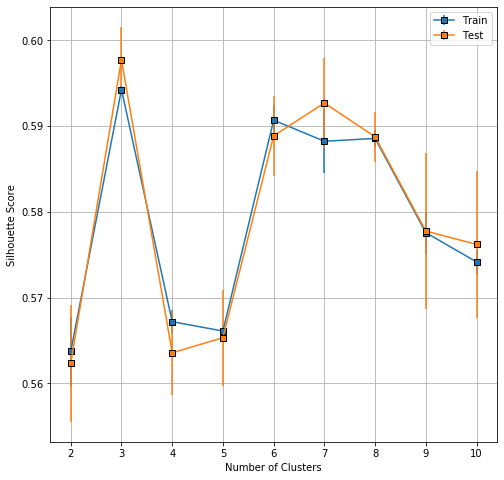

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
df_plot = df_silhouette_avg.groupby("n_cluster")
for set_label in ["train", "test"]:
    ax.errorbar(df_plot.mean().index, 
                df_plot.mean()[set_label + "_silhouette"].values, 
                df_plot.std()[set_label + "_silhouette"].values, label=set_label.title(),
               marker='s', mec='black')
ax.grid(True)
ax.legend()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

Based on this plot, we can infer that `3` or `6` clusters are probably recommended for making data-drive customer profiles. In order to make a final decision, we shall analyse each variable, including those ones that were not user for training and have business value. 

To be continued

In [210]:
chosen_n_clusters = [3,6,7]
for n_cluster in chosen_n_clusters:
    model = KMeans(n_clusters=n_cluster, random_state=0).fit(X)    
    profile["cluster_" + str(n_cluster)] = model.predict(X)

In [211]:
profile_columns = ["days_since_subscription"] + ["cluster_" + str(n_cluster) for n_cluster in chosen_n_clusters]
for column in profile_columns:
    if column in df_offers.columns:
        df_offers.drop(column, axis=1, inplace=True)

In [213]:

df_offers = pd.merge(df_offers, 
                     profile[["person", "days_since_subscription"] + ["cluster_" + str(n_cluster) for n_cluster in chosen_n_clusters]], 
                     how="inner", on="person")

In [214]:
df_offers.head()

,person,time,offer_id,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,...,offered_reward,age,became_member_on,gender,income,cluster_2,days_since_subscription,cluster_3,cluster_6,cluster_7
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,1,24,0,NaN,0.00,1,0,...,0,33.0,2017-04-21,M,72000.0,0,1082,2,4,2
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,1,36,0,NaN,0.00,1,0,...,0,33.0,2017-04-21,M,72000.0,0,1082,2,4,2
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1,48,1,6.0,8.57,0,1,...,5,33.0,2017-04-21,M,72000.0,0,1082,2,4,2
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1,36,1,24.0,14.11,0,1,...,2,33.0,2017-04-21,M,72000.0,0,1082,2,4,2
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1,36,1,0.0,10.27,0,1,...,2,33.0,2017-04-21,M,72000.0,0,1082,2,4,2


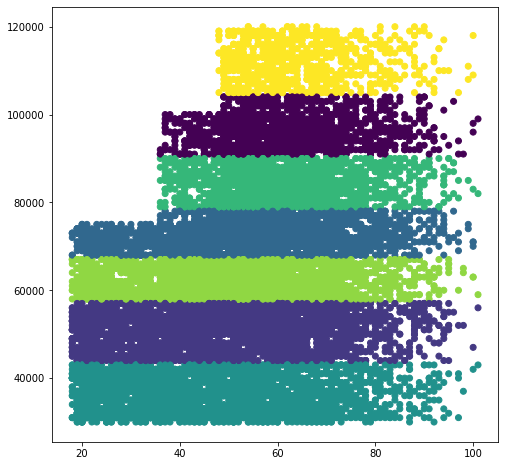

In [218]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(profile["age"], profile["income"], c=profile["cluster_7"])

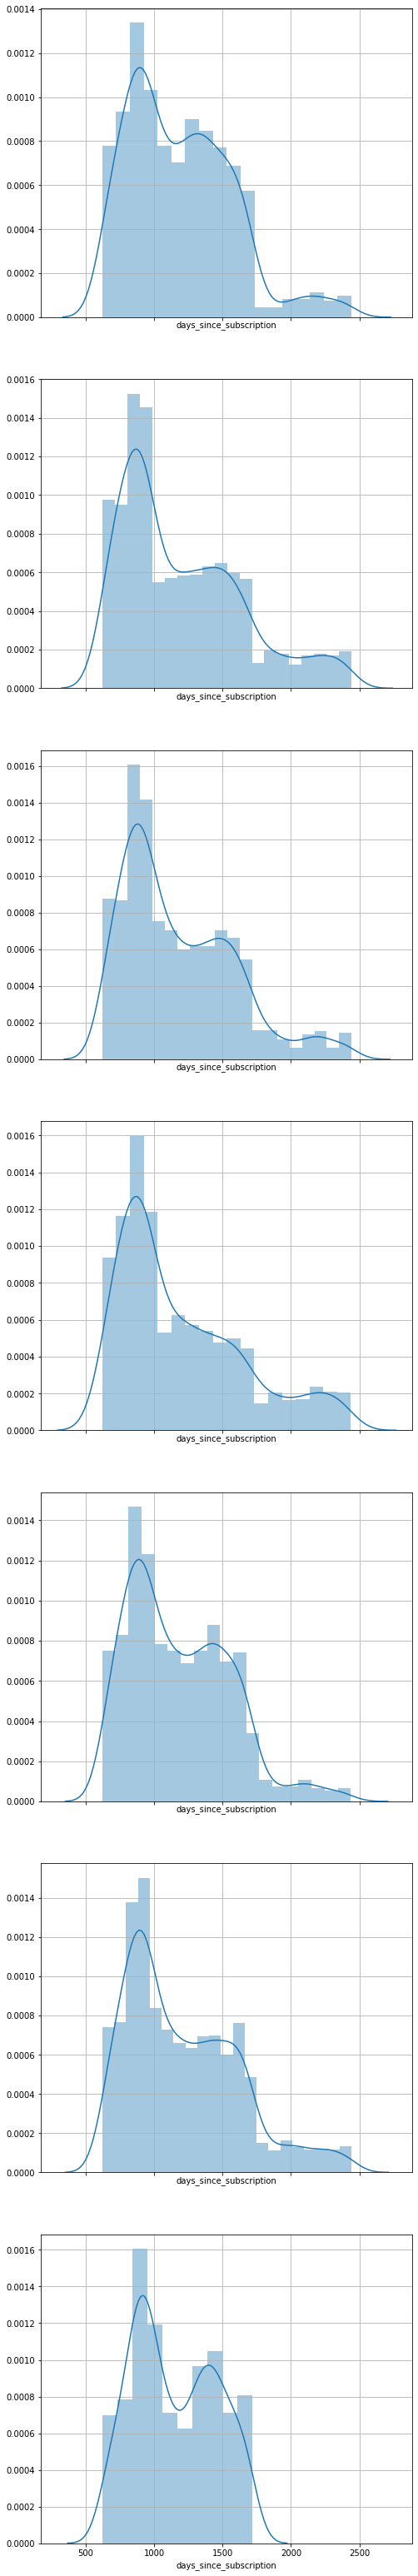

In [219]:
n_cluster = 7
fig, axes = plt.subplots(nrows=n_cluster, ncols=1, figsize=(8, n_cluster*8), sharex=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    df_temp = profile[profile["cluster_" + str(n_cluster)] == i].copy()
    sns.distplot(df_temp.dropna()['days_since_subscription'], ax=ax)
    ax.grid(True)

In [224]:
df_offers.groupby(["cluster_7"]).mean()

,time,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,difficulty,duration,...,bogo,informational,discount,offered_reward,age,income,cluster_2,days_since_subscription,cluster_3,cluster_6
cluster_7,,,,,,,,,,,,,,,,,,,,,
0,335.119974,1.0,25.742683,0.608556,56.210359,17.987097,0.202959,0.389032,7.627533,155.023480,...,0.405757,0.204246,0.389997,4.235606,62.010454,96458.346735,0.000000,1164.827115,0.000000,1.464458
1,333.147414,1.0,24.496422,0.434676,64.063029,6.707024,0.485927,0.323860,7.679956,155.907585,...,0.397601,0.203571,0.398828,4.185783,50.810605,51205.752062,1.000000,1142.206706,1.254413,0.164384
2,331.690090,1.0,24.936937,0.527156,58.515625,11.358518,0.342085,0.367482,7.799399,156.857658,...,0.398713,0.195367,0.405920,4.233119,55.637752,72615.358215,0.268211,1137.656628,2.000000,3.463578
3,332.857591,1.0,27.253364,0.346817,71.827184,4.409714,0.597705,0.265252,7.761661,156.637002,...,0.399653,0.197391,0.402956,4.203088,48.142657,36536.035664,1.000000,1120.269958,1.000000,3.000000
4,333.069915,1.0,24.931144,0.616658,57.326605,16.193951,0.210540,0.404661,7.779131,157.013771,...,0.398702,0.197166,0.404131,4.205244,61.527542,84355.534958,0.000000,1162.778867,0.544492,2.527410
5,332.190718,1.0,24.309233,0.305129,66.503362,4.861527,0.601172,0.217636,7.641768,155.484123,...,0.400537,0.200733,0.398730,4.185002,53.086863,63179.872985,1.000000,1128.871568,2.000000,1.891939
6,328.998888,1.0,31.743604,0.617631,59.321927,19.542970,0.203560,0.380979,7.706340,155.833148,...,0.401557,0.197998,0.400445,4.187152,64.872636,111953.281424,0.000000,1135.967742,0.000000,5.000000


In [225]:
df_offers.groupby(["cluster_7"]).sum()

,time,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,difficulty,duration,...,bogo,informational,discount,offered_reward,age,income,cluster_2,days_since_subscription,cluster_3,cluster_6
cluster_7,,,,,,,,,,,,,,,,,,,,,
0,2083776,6218,160068,3784,212700.0,111843.77,1262,2419,47428,963936,...,2523,1270,2425,26337,3.855810e+05,5.997780e+08,0,7242895,0,9106
1,4888272,14673,359436,6378,408594.0,98412.17,7130,4752,112688,2287632,...,5834,2987,5852,61418,7.455440e+05,7.513420e+08,14673,16759599,18406,2412
2,3865848,11655,290640,6144,359520.0,132383.53,3987,4283,90902,1828176,...,4647,2277,4731,49337,6.484580e+05,8.463320e+08,3126,13259388,23310,40368
3,4031904,12113,330120,4201,301746.0,53414.87,7240,3213,94017,1897344,...,4841,2391,4881,50912,5.831520e+05,4.425610e+08,12113,13569830,12113,36339
4,2515344,7552,188280,4657,266970.0,122296.72,1590,3056,58748,1185768,...,3011,1489,3052,31758,4.646560e+05,6.370530e+08,0,8781306,4112,19087
5,6799944,20470,497610,6246,415380.0,99515.46,12306,4455,156427,3182760,...,8199,4109,8162,85667,1.086688e+06,1.293292e+09,20470,23108001,40940,38728
6,1183080,3596,114150,2221,131754.0,70276.52,732,1370,27712,560376,...,1444,712,1440,15057,2.332820e+05,4.025840e+08,0,4084940,0,17980


In [227]:
df_offers.to_csv(os.path.join(data_dir, "clusters.csv"), sep=';', index=None)

In [230]:
df_offers["reward"] = df_offers["offer_viewed"] + \
        df_offers["offer_completed"]*df_offers["offered_reward"] + \
        2*df_offers["future_purchase"]

In [244]:
channels = ["email", "mobile", "social", "web"]
df_clusters = pd.DataFrame(columns=["cluster"] + channels)
for cluster in df_offers["cluster_7"].unique():
    df_temp = df_offers[df_offers["cluster_7"] == cluster]
    row = [cluster]
    for channel in channels:
        row.append(df_temp[df_temp[channel] == 1]["reward"].mean())
    
    df_clusters.loc[df_clusters.shape[0]] = row
    
df_clusters

,cluster,email,mobile,social,web
0,2.0,4.378636,4.380214,5.005342,4.340991
1,5.0,2.862042,2.876472,3.198133,2.896061
2,1.0,3.740953,3.738451,4.201678,3.776628
3,4.0,4.976827,4.902987,5.633856,4.867344
4,0.0,4.975394,4.892113,5.654980,4.858883
5,6.0,4.950501,4.882371,5.721501,4.903170
6,3.0,3.086601,3.118249,3.432002,3.206043


In [251]:
import random
def get_reward(df_clusters, item):    
    return random.choice(df_clusters[item].values)

get_reward(df_clusters, "social")

3.198133116883117

In [259]:
np.random.choice(4)

2

In [239]:
df_offers[["cluster_7", "email", "mobile", "social", "web", "reward"]].head()

,cluster_7,email,mobile,social,web,reward
0,2,1,1,1,0,1
1,2,1,1,0,1,1
2,2,1,1,1,1,8
3,2,1,1,1,1,5
4,2,1,1,0,1,5
